# Paper - Example 3

In [ ]:
# TODO 
# Update pyvista : 0.37 -> 0.41
# Insert ref to pyvista documentation
    # add_text : https://docs.pyvista.org/version/stable/api/plotting/_autosummary/pyvista.Plotter.add_text.html
    # add_mesh : https://docs.pyvista.org/version/stable/api/plotting/_autosummary/pyvista.Plotter.add_mesh.html
    
# file format
    # LUDO : ouvrir les fichiers .tif ?
    # que des .asc / pas de .tif ???
    # remove rasterio ??

# case
    # correction of the density of the fractures families
    # failles : values ???
    

In [1]:
# Import the pyKasso package
import pykasso as pk
import matplotlib.pyplot as plt
import numpy as np

# Create a pyKasso application
app = pk.pykasso()

# Declare the grid parameters
grid_parameters = {
    'x0': 2582750,
    'y0': 1127767,
    'z0': 1000,
    'nx': 394,
    'ny': 193,
    'nz': 100,
    'dx': 20,
    'dy': 20,
    'dz': 20,
}

# Declare the project parameters
app.new_project(project_name='example_03', grid_parameters=grid_parameters)
nx, ny, nz = app.model.grid.shape
app.visualizer.notebook = True
dr = pk.DataReader(grid=app.project.grid)
input_dir = 'example_03/inputs/'
extent = app.project.grid.extent

## Visualize and define the model variables

### Topography

Figure(fig=<Figure size 640x480 with 2 Axes>, ax=<Axes: xlabel='x', ylabel='y'>, cbar=<matplotlib.colorbar.Colorbar object at 0x0000017F9A6CD6D0>)

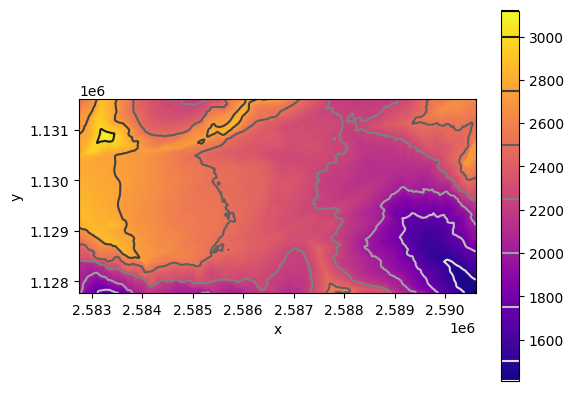

In [2]:
# Load
fname = input_dir + 'DEM.tif'
topography = dr.get_data_from_file(fname)

# Plot
imshow_options = {
    'extent' : extent,
    'cmap' : 'plasma'
}
contour_options = {
    'cmap' : 'binary'
}
app.visualizer.mpl_plot_array_2D(topography,
                                 imshow_options=imshow_options,
                                 contour_options=contour_options)

### Bedrock

Figure(fig=<Figure size 640x480 with 2 Axes>, ax=<Axes: xlabel='x', ylabel='y'>, cbar=<matplotlib.colorbar.Colorbar object at 0x0000017F9C7684C0>)

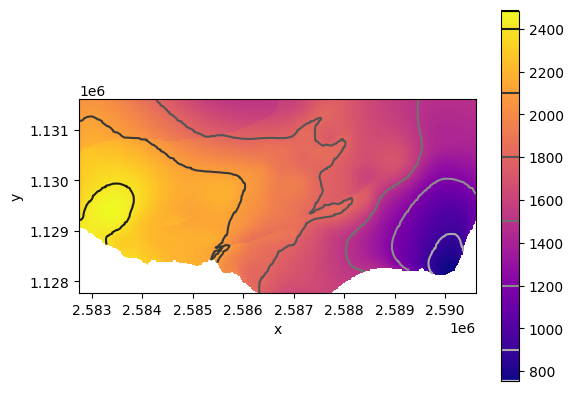

In [3]:
# Load
fname = input_dir + 'Bot_urgonien.tif'
bedrock = dr.get_data_from_file(fname)
bedrock = bedrock - 300
bedrock[bedrock < 0] = np.nan

# Plot
imshow_options = {
    'extent' : extent,
    'cmap' : 'plasma'
}
contour_options = {
    'cmap' : 'binary',
    'levels' : [i*300 for i in range(10)]
}
app.visualizer.mpl_plot_array_2D(bedrock,
                                 imshow_options=imshow_options,
                                 contour_options=contour_options)

### Geologic model

In [ ]:
# # Load          ################## TODOOOOOOOOOOOOOOO##############
# app.visualizer.notebook = False
# fname = input_dir + 'tsanfleuron_20m_XYZ.vox'
# df = dr.get_dataframe_from_file(fname)
# # geology = dr.get_data_from_file(fname)
# # geology
# # app.visualizer.pv_plot_array(geology)
# # geology = np.genfromtxt(fname, skip_header=2)

In [ ]:
# df['X'] = df['X'] + 2000000
# df['Y'] = df['Y'] - 40000
# # 'x0': 2582750,
# # 'y0': 1127767,

In [ ]:
# # Plot
# app.visualizer.notebook = False
# geology = dr._get_data_from_vox_df(df)
# app.visualizer.pv_plot_array(geology)

### Faults

In [ ]:
# # Load
# input_dir = 'example_03/inputs/'
# fname = input_dir + 'tsanfleuron_20m_DistancesToFaults_XYZ.vox'
# faults = dr._get_dataframe_from_vox(fname, nrows=10)
# faults
# # faults[['X', 'Y']]

In [ ]:
# a = "X Y Z Chevauchement NEESOO1 NEESOO2 NESO1 NESO11 NESO2 NESO22 NESO3 NESO32 NESO4 NESO42 NESO43 NESO44 NESO5 NESO6 NESO7 NOOSEE1 NOOSEE2 NOOSEE3 NS2 OE1 dmin"
# b = "582760  1.26778e+006 1010 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 8999.67"
# print(len(a.split(' ')))
# print(len(b.split(' ')))

In [ ]:
# # Load
# fname = input_dir + 'Faille_Pykasso_MODELE_G_394x193.csv'
# faults = dr.get_data_from_file(fname)

# # Plot
# imshow_options = {
#     'extent' : extent,
#     'cmap' : 'binary'
# }
# app.visualizer.mpl_plot_array_2D(faults,
#                                  imshow_options=imshow_options)

### Outlets

In [4]:
# Load
fname = input_dir + 'Outlet_ModeleG.txt'
outlet = dr.get_data_from_file(fname)
outlet[0] = outlet[0] - 300

# Plot
# x, y = outlet
# app.visualizer.mpl_plot_array_2D(bedrock, imshow_options={'extent':extent})
# plt.scatter(x,y)

### Water level

In [5]:
i, j = app.model.grid.get_indices(outlet)
level = topography[i, j]
water_level = np.full((nx, ny), level)
# level
# # topography = np.linspace(2500, 1500, grid_parameters['nx'])
# # topography = np.repeat(topography[:, np.newaxis], grid_parameters['ny'], axis=1)

### Ratio array

In [6]:
# ratio = np.full_like(app.project.grid.data_volume, 0.2)
# indices = np.indices(ratio.shape)
# z_i = indices[2] + 1
# z_i = z_i / z_i.max()
# z_i = np.flip(z_i, axis=2)
# app.visualizer.pv_plot_array(z_i)

In [7]:
# TODO - produire une erreur quand numpy array invalide en entrée

## Gradient

In [8]:
# Load
fname = input_dir + 'tsanfleuron_20m_Gradients_XYZ.vox'
df = dr.get_dataframe_from_file(fname, nrows=10)
df

grad_X = df[['X', 'Y', 'Z', 'vx']]
grad_Y = df[['X', 'Y', 'Z', 'vy']]
grad_Z = df[['X', 'Y', 'Z', 'vz']]
# grad_X = dr._get_data_from_vox_df(grad_X)
# grad_X

## Set the model

In [9]:
# Declare the model parameters
model_parameters = {
    'sks' : {
        'algorithm' : 'Riemann3',
        'mode' : 'D',
        # 'factors' : {
        #     'F' : 33,
        #     'F1' : 10,
        #     'F2' : 20,
        # },
        'costs': {
            'ratio' : 0.05,
            'faults' : 0.02,
        }
    },
    'domain' : {
        'topography' : 'DEM.tif',
        'bedrock': bedrock,
        'water_level' : water_level,
    },
    'outlets' : {
        # 'data' : 'Outlet_ModeleG.txt',
        # 'data' : [outlet.tolist()], # TEST pour [[]]
        'data' : outlet, # TEST pour [[]]
        'number' : 1,
        'importance': [1],
        'subdomain' : 'domain_surface', 
    },
    'inlets' : {
        'data' : 'Inlets_ModeleG.txt',
        'number': 22,
        'importance': [1, 1, 2],
        # 'importance': [1],
        'per_outlet': [1],
    },
    'faults' : {
        'data' : 'Faille_Pykasso_MODELE_G_394x193.csv'
        # 'data' : faults,
        # 'costs' : {1: 0.02}
    },
    'fractures' : {
        # 'seed': 111111,
        'settings': {
            'family_01': {
                'alpha'        : 1.4,
                'density'      : 4.5e-4,
                'orientation'  : [32, 86],
                'dip'          : 90,
                'length'       : [20, 400],
            },
            'family_02': {
                'alpha'        : 1.2,
                'density'      : 1.2e-4,
                'orientation'  : [146, 196],
                'dip'          : 90,
                'length'       : [20, 130],
            },
            'family_03': {
                'alpha'        : 2.1,
                'density'      : 4.5e-4,
                'orientation'  : [98, 163],
                'dip'          : 90,
                'length'       : [20, 740],
            },
            'family_04': {
                'alpha'        : 1.8,
                'density'      : 2.8e-4,
                'orientation'  : [72, 115],
                'dip'          : 90,
                'length'       : [20, 160],
            }
        }
    }
}

In [ ]:
# def test():
#     model_parameters['sks']['seed'] = 1
#     # app.model.model_parameters = model_parameters
#     # app.model._initialize()
#     # app.model._build()
#     app.model.generate(model_parameters=model_parameters)

# import cProfile
# import pstats
# a = cProfile.run('test()', 'profile_results')
# stats = pstats.Stats('profile_results')
# stats.sort_stats('tottime').print_stats()

In [10]:
# Compute 10 simulations
for i in range(1):
    model_parameters['sks']['seed'] = i
    # app.model.model_parameters = model_parameters
    # app.model._initialize()
    # app.model._build()
    app.model.generate(model_parameters=model_parameters)

C:\Users\franc\OneDrive\Desktop\pykasso\pykasso\pykasso\core\grid.py:436: RuntimeWarning: invalid value encountered in cast
  k = k.astype('int32')


## Geologic model

In [ ]:
imshow_options = {'cmap': 'binary'}

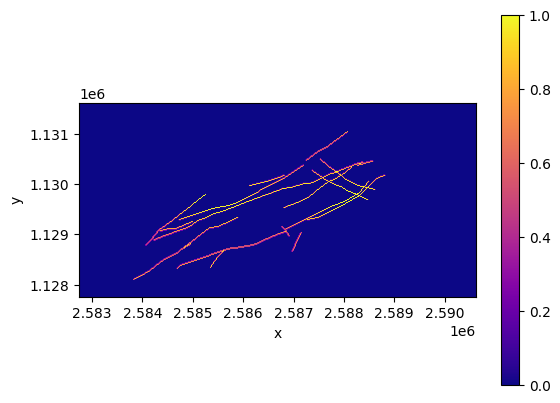

In [17]:
# Plot the faults model
f01 = app.visualizer.mpl_plot_2D(feature='faults',
                                 imshow_options=imshow_options,
                                 )
f01.fig.savefig('fig/example_03_faults')

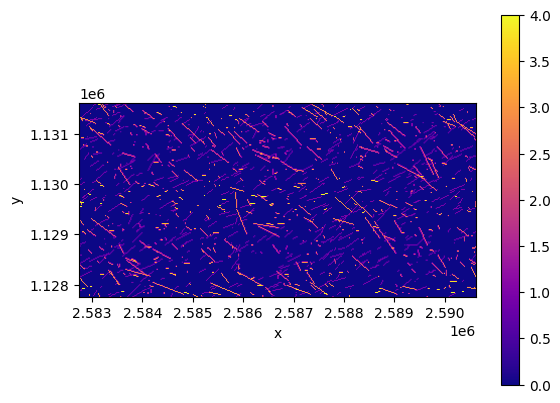

In [18]:
# Plot the fracturation model
f02 = app.visualizer.mpl_plot_2D(feature='fractures',
                                 imshow_options=imshow_options,
                                 )
f02.fig.savefig('fig/example_03_fractures')

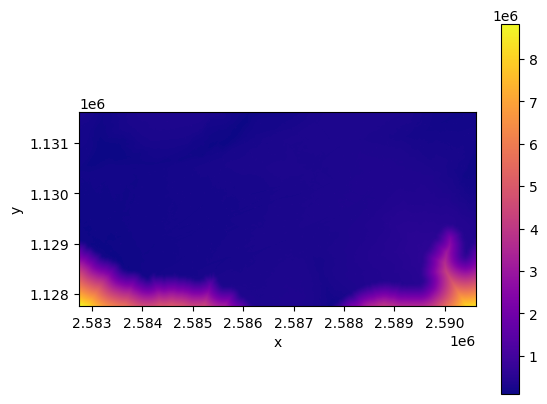

In [23]:
# Plot the topography
f03 = app.visualizer.mpl_plot_2D(feature='time',
                                 imshow_options=imshow_options,
                                #  scatter_inlets_options={},
                                #  scatter_outlets_options={},
                                 )
f03.fig.savefig('fig/example_03_time')

## Fracturation analysis

In [24]:
fractures = app.model.fractures.fractures
families = app.model.fractures.families

hist_settings = {
    'by' : 'family_id',
    'bins' : 10,
    'layout' : (2,2),
    'density' : True
}

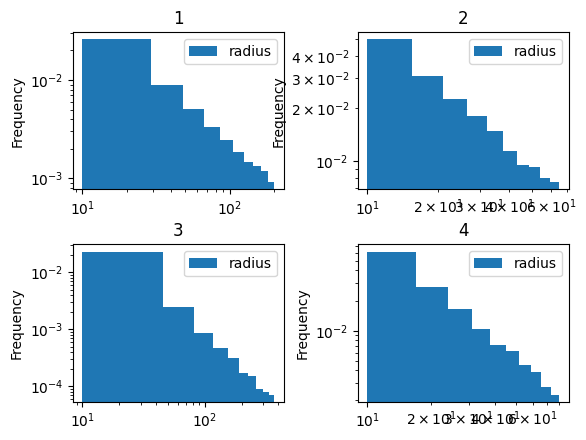

In [25]:
# Radius
axes = fractures.plot.hist(column='radius', logy=True, logx=True, **hist_settings)
plt.subplots_adjust(hspace=0.35, wspace=0.35)


array([[<Axes: title={'center': '1'}, ylabel='Frequency'>,
        <Axes: title={'center': '2'}, ylabel='Frequency'>],
       [<Axes: title={'center': '3'}, ylabel='Frequency'>,
        <Axes: title={'center': '4'}, ylabel='Frequency'>]], dtype=object)

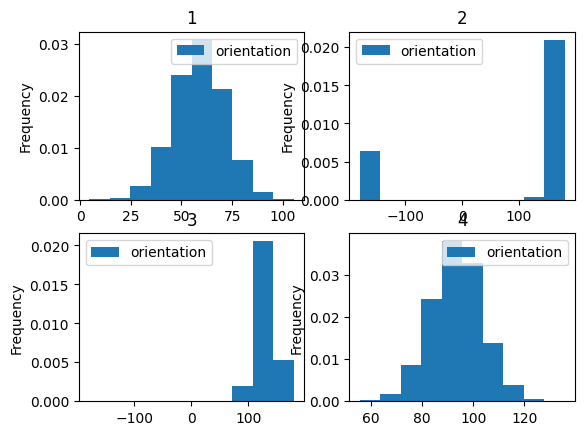

In [26]:
# Orientation
fractures.plot.hist(column='orientation', **hist_settings)

array([[<Axes: title={'center': '1'}, ylabel='Frequency'>,
        <Axes: title={'center': '2'}, ylabel='Frequency'>],
       [<Axes: title={'center': '3'}, ylabel='Frequency'>,
        <Axes: title={'center': '4'}, ylabel='Frequency'>]], dtype=object)

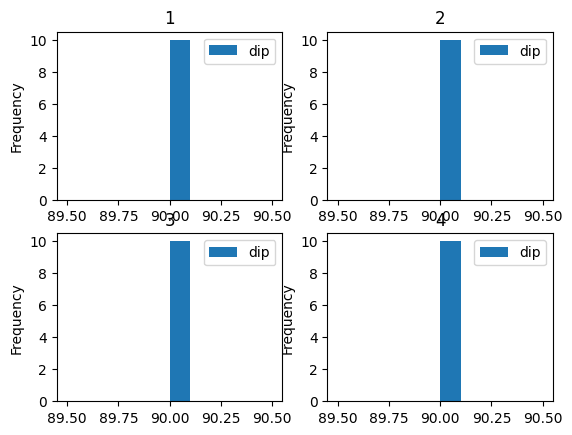

In [27]:
# Dip
fractures.plot.hist(column='dip', **hist_settings)

## Results in 2D

In [ ]:
imshow_options = {'cmap': 'binary'}

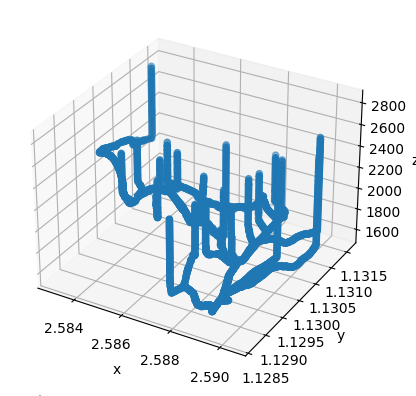

In [29]:
# Plot the last simulated karstic conduit network
f04 = app.visualizer.mpl_plot_karstic_network()
f04.fig.savefig('fig/example_03_karst')

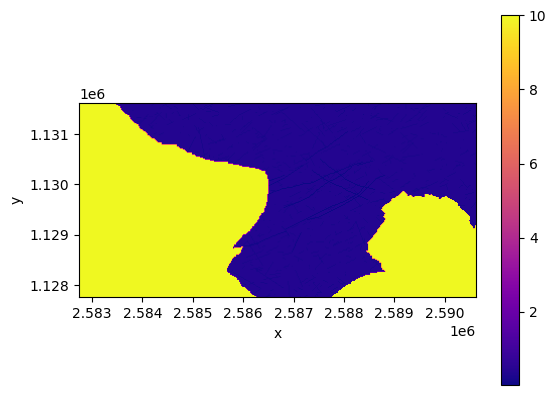

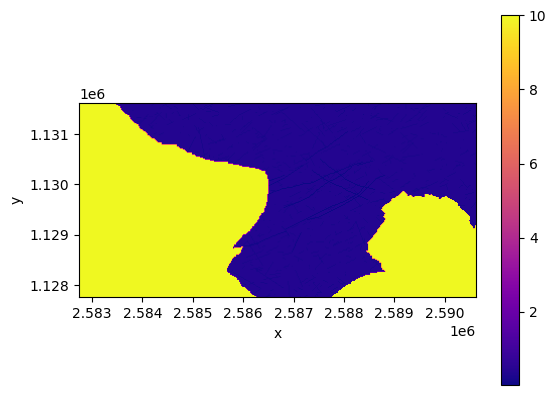

In [33]:
# Plot the cost array
f05 = app.visualizer.mpl_plot_2D(feature='cost',
                                 n_slice=50,
                                 imshow_options=imshow_options,
                                 )
f05.fig.savefig('fig/example_03_cost')
f05.fig

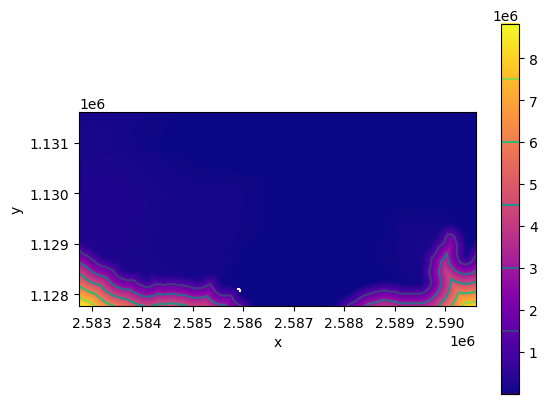

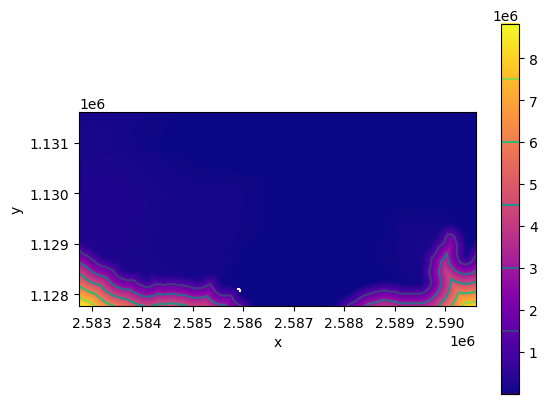

In [36]:
# Plot the time travel array
f06 = app.visualizer.mpl_plot_2D(feature='time',
                                 n_slice=50,
                                 imshow_options=imshow_options,
                                 contour_options={},
                                 )
f06.fig.savefig('fig/example_03_time')
f06.fig

In [ ]:
# Compute the mean of all the simulated karstic networks
# mean = app.analyzer.compute_stats_on_networks('mean')
# extent = app.project.grid.extent
# imshow_options = {
#     'extent' : extent,
#     'cmap' : 'binary',
#     'vmin' : 0,
#     'vmax' : 0.1
# }
# settings = {
#     'ghost_values' : [0],}
# im05 = app.visualizer.mpl_plot_array_2D(mean, imshow_options=imshow_options)
# im05 = app.visualizer.pv_plot_array(mean, [0])#, imshow_options=imshow_options)
# im05.savefig('fig/example_03_mean_karstic_network')
# im05

## Results in 3D

In [ ]:
settings = {
    # 'text_options' : {
    # #     'text': '',
    # #     'position': 'upper_left',
    # #     'font_size': 18,
    # #     'color': None,
    # #     'font': None,
    # #     'shadow': False,
    # #     'name': None,
    # #     'viewport': False,
    # #     'orientation': 0.0
    # },
    # 'n_iteration' : -1,
    # 'ghost_values' : [10, 0.4],
    'ghost_values' : [0],
    # 'ghost_values' : [10, 0.4],
    # # 'ghost_subdomains' : ['domain_surface'],
    # 'show_grid' : False,
    # 'show_outline': True,
    # 'data_options': {},
    'surfaces_options' : {
        'bedrock' : {},
        # 'topography' : {},
        # 'water_level' : {}
    },
    # 'inlets_options' : {},
    # 'outlets_options' : {},
    # # 'show_slice' : True,
    # 'show_colorbar' : True
    # 'fractures_options': {
    #     # 'family_id': [2,3],
        # 'n': 200,
    # },
}

app.visualizer.notebook = False

In [ ]:
# last_sims = app.project.get_last_simulations(9)
# app.visualizer.pv_show(simulations=last_sims,
#                        features=['karst'],
#                        settings=settings)

In [ ]:
app.visualizer.pv_show(simulations=[-1],
                       features=['karst'],
                       settings=settings)